In [ ]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Linear regression problem is an optimization problem

$$
w = \arg\min \|Y - X^T w\|^2
$$

# HOW TO SOLVE?

$$
w = (X^T X )^{-1}X^T y
$$




But matrix $X$ could be very long and to do all the multiplications directly is insane!

# QR DECOMPOSITION
may help
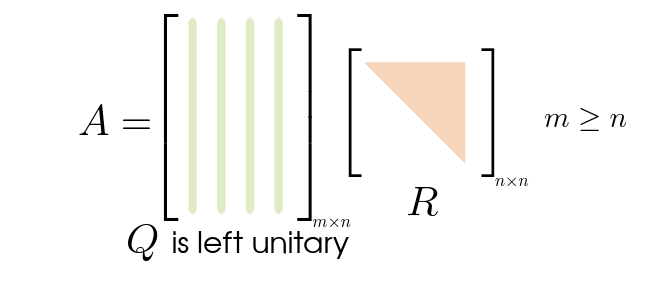

## How does it help?

Let $X = QR$  then

$$
w = (X^T X )^{-1}X^T y = (R^T Q^T Q R )^{-1}R^T Q^T y =  (R^T R )^{-1}R^T Q^T y = ( R )^{-1} Q^T y
$$


## How to get QR decomposition ?  - Gram Schmidt process!




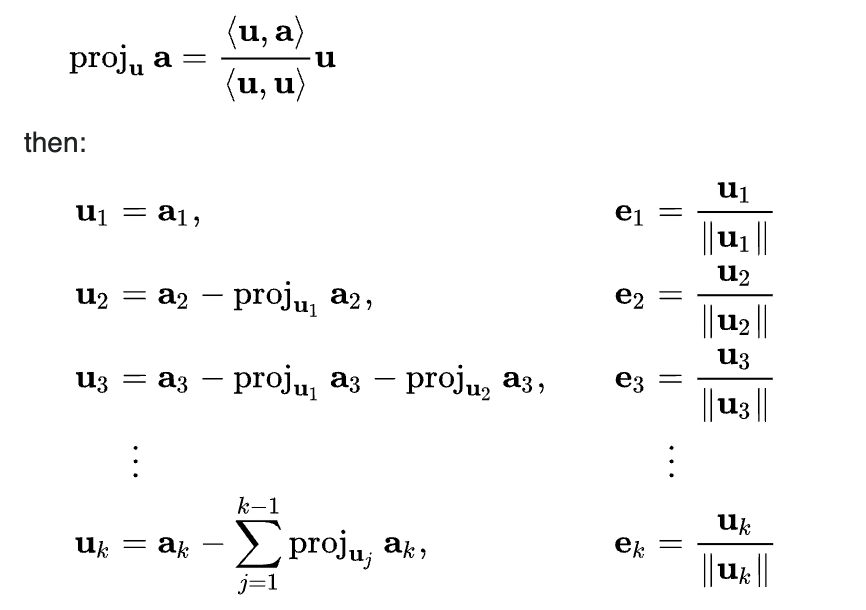

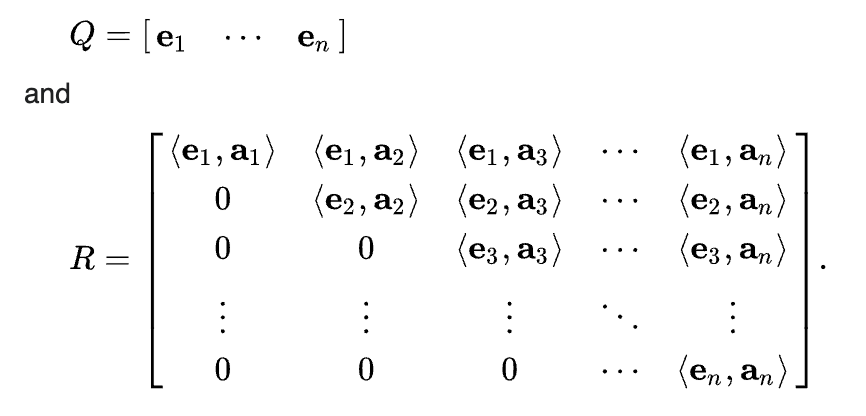

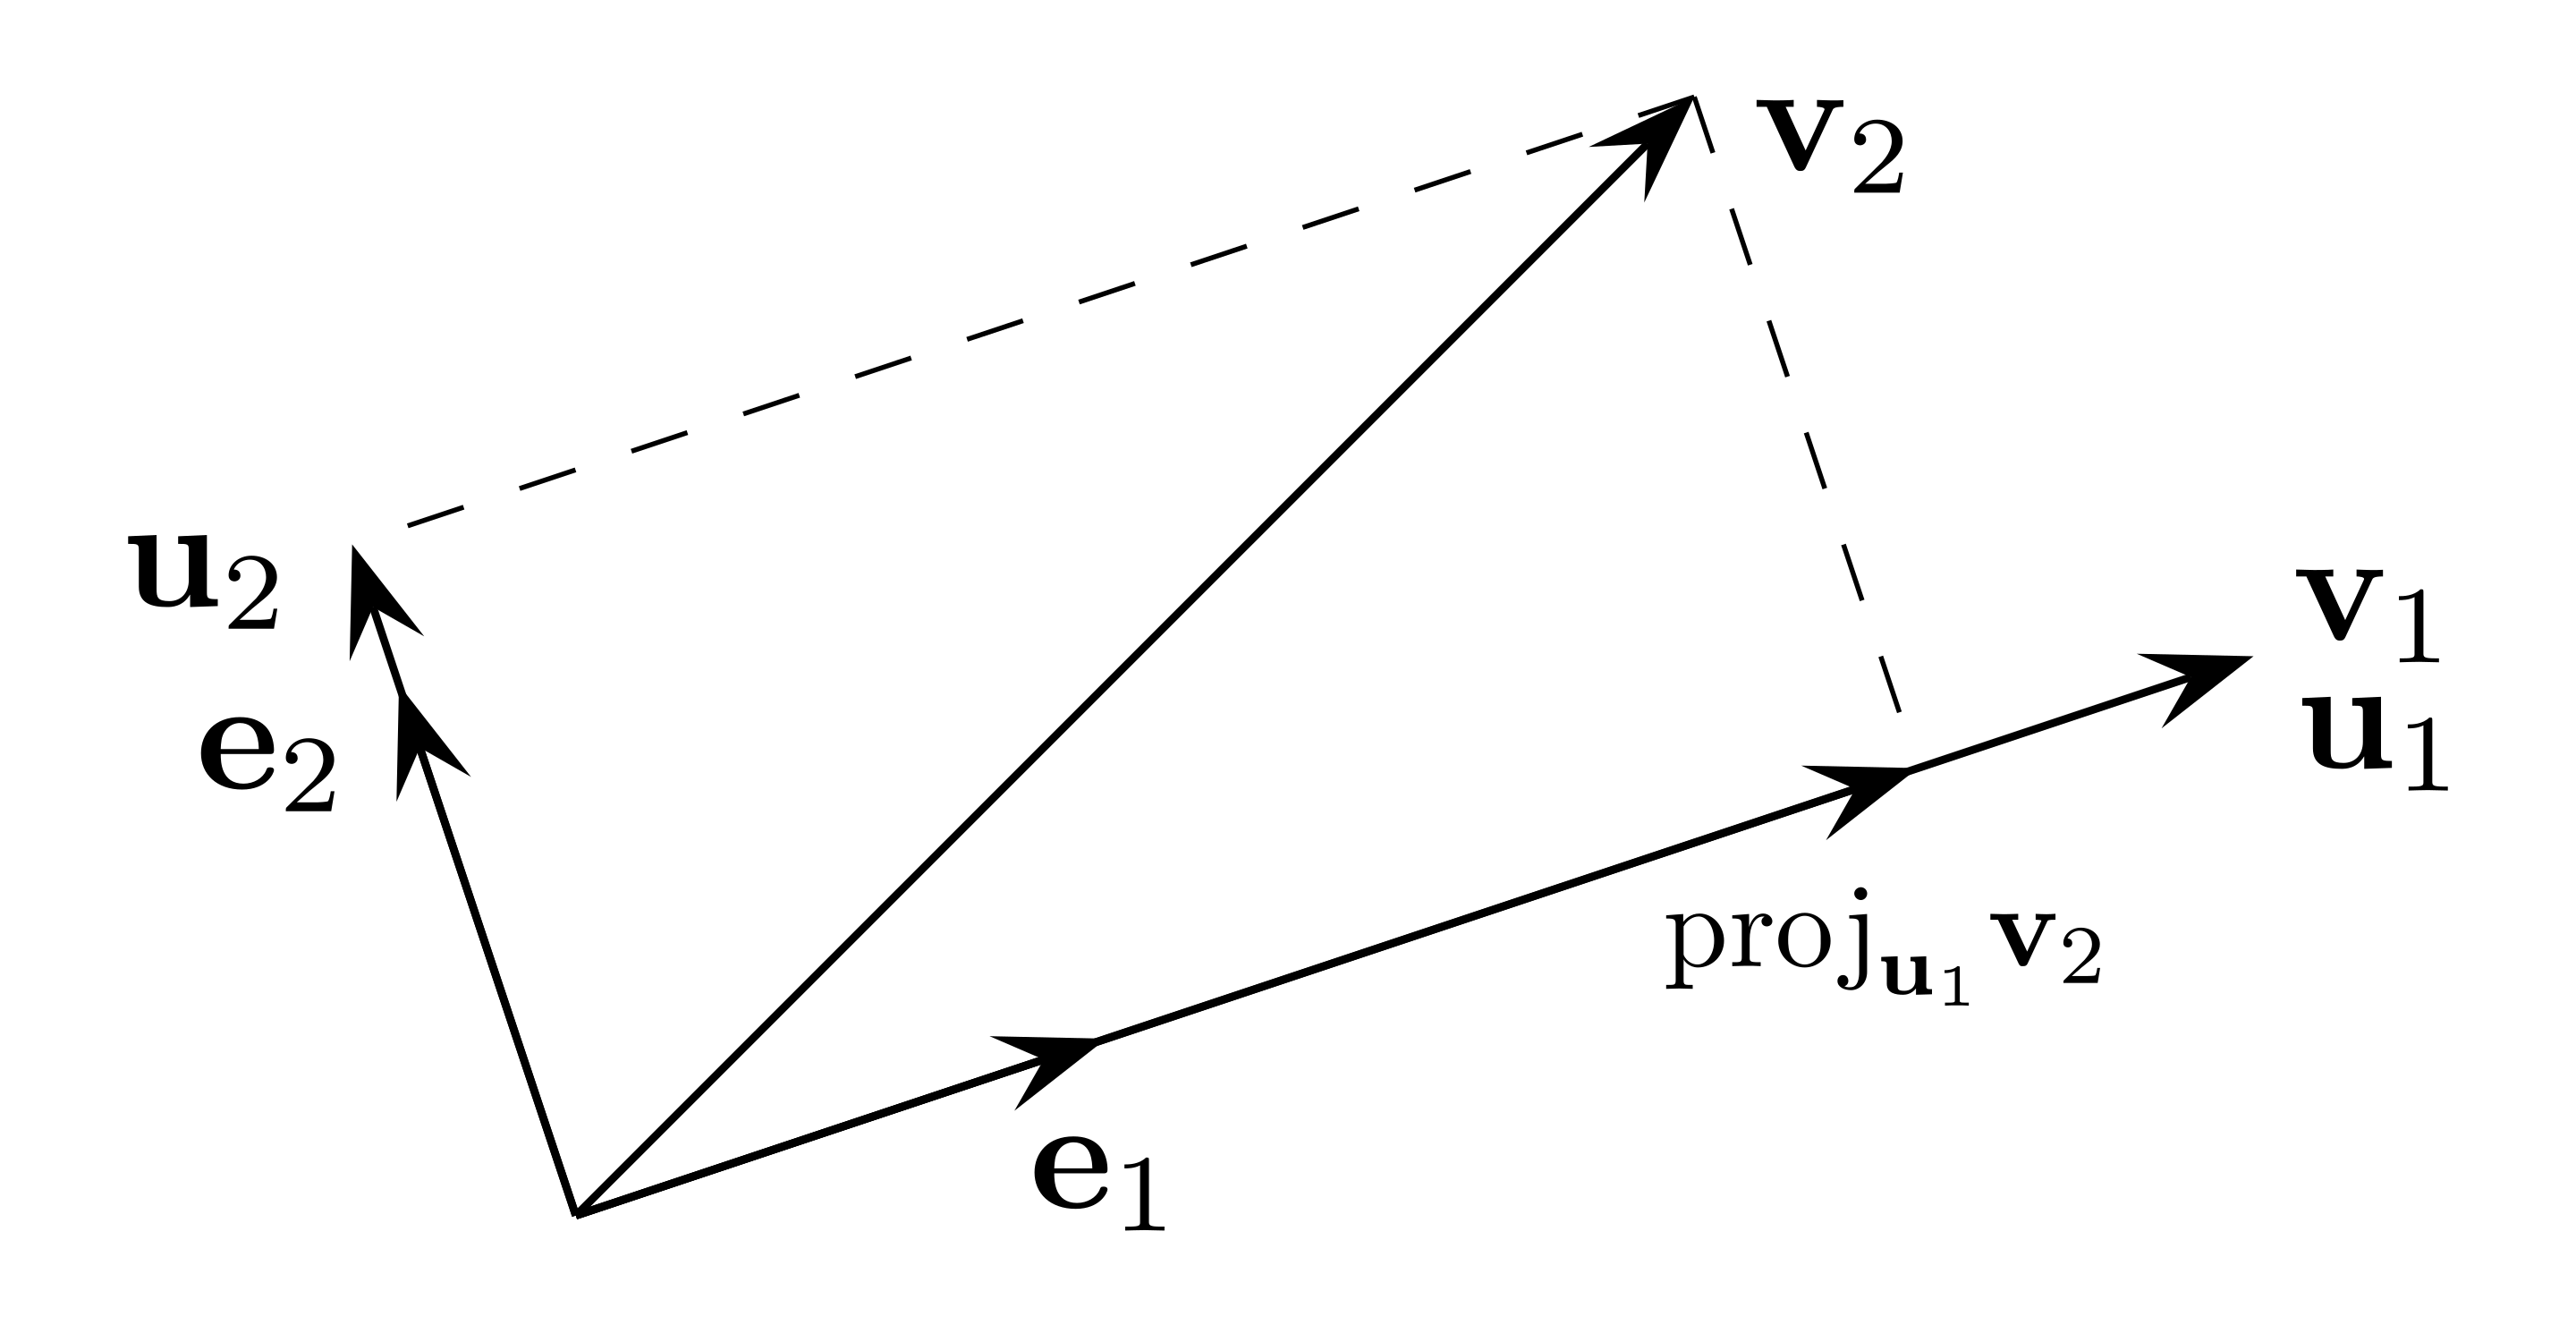

In [ ]:
def proj(u,a):
  return (u @a) * u /( u @ u )

In [ ]:
def QR (A):
  Q = A.copy()
  R = np.zeros(A.shape)
  rows, cols = A.shape
  for col in range(cols):
    a_col = Q[:, col].copy()
    for j in range(col):
      u_j = Q[:, j].copy()
      Q[:, col] -= proj(u_j, a_col)
    Q[:, col] /= np.linalg.norm( Q[:, col])
    for row in range(col+1):
      R[row, col] = A[:, col] @ Q[:, row]

  return Q, R[:R.shape[1], :]

In [ ]:
# Sanity check

mat = np.random.rand(6,4)
q, r = QR(mat)

assert np.allclose(np.linalg.norm(q@r - mat),0)

# LET'S GET DOWN TO OUR FIRST LINEAR REGRESSION

## BUT data first

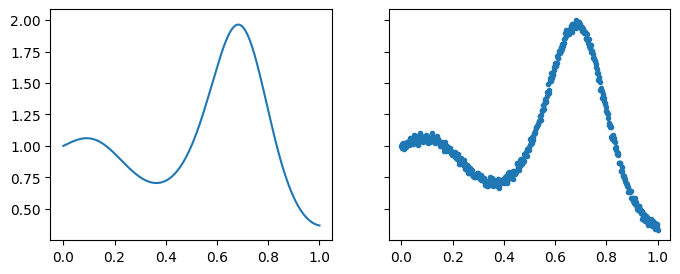

In [ ]:
N_samples = 500
x = np.linspace(0, 1, N_samples)
np.random.seed(4)
y = np.exp(np.cos(3*np.pi*x)*x)
noise = 0.02*np.random.randn(*x.shape)

fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
ax[0].plot(x, y)
ax[1].plot(x, y + noise, ".");

The function we want to predict is nonlinear, obviously. But we have **linear** regression! What is to be done?

The answer is simple: choose features accurately!

**Linear** in linear regression goes for linear dependence on features

In [ ]:
np.random.seed(11)
ind = np.arange(N_samples, dtype=int)
ind_train = np.random.choice(ind, size=(300,), replace=False)
ind_test = np.array(list(set(ind) - set(ind_train)))

x_train, x_test = x[ind_train], x[ind_test]
y_train, y_test = y[ind_train] + noise[ind_train], y[ind_test]

n_poly = 8
f_train = np.stack([x_train**k for k in range(n_poly)], 1)
f_test = np.stack([x_test**k for k in range(n_poly)], 1)

# LETS IMPLEMENT OUR FIRST LINEAR REGRESSION

In [ ]:
class LinearRergession():
    '''LinearRergession with direct solution
    '''
    def __init__(
        self,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=5000,
    ) -> None:

        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps



    def fit (self, X_train, y_train):
        q,r = QR(X_train)
        # w = np.linalg.solve(r, q.T @ y_train)
        w = np.linalg.pinv(r) @ q.T @ y_train
        self.w = w
        return self



    def predict(self, X):
        return X@self.w

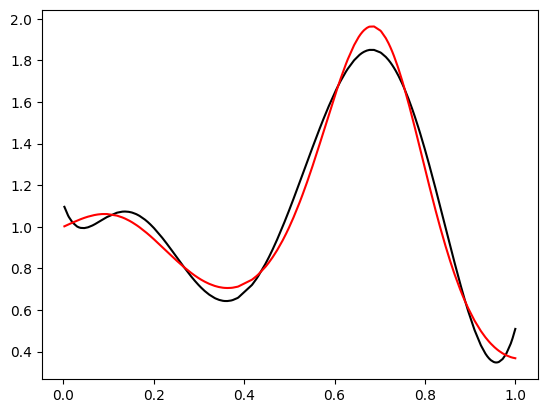

In [ ]:


own_lr = LinearRergession(lr=1e-5, num_steps=50000).fit(f_train, y_train)

y_pred = own_lr.predict(f_test)

plt.plot(x_test, y_pred, color="black")
plt.plot(x_test, y_test, color="red");

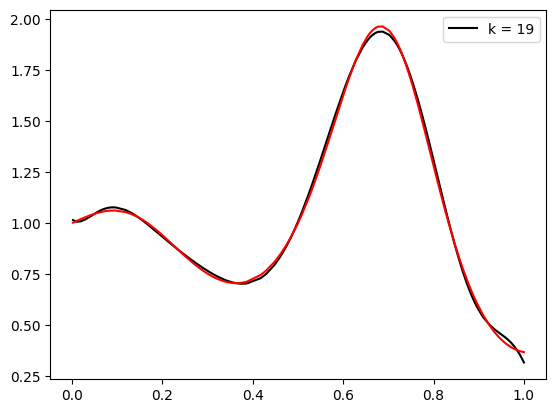

In [ ]:
from IPython.display import clear_output

for n_poly in range(1,20):
    f_train = np.stack([x_train**k for k in range(n_poly)], 1)
    f_test = np.stack([x_test**k for k in range(n_poly)], 1)
    own_lr = LinearRergession(lr=1e-5, num_steps=50000).fit(f_train, y_train)

    y_pred = own_lr.predict(f_test)
    line = 'k = {}'.format(n_poly)
    plt.plot(x_test, y_pred, color="black", label=line)
    plt.plot(x_test, y_test, color="red");

    plt.legend()

    plt.show()
    clear_output(wait=True)

Another way to solve linear regression problem

$$
w = \arg\min \|Y - X^T w\|^2
$$

is iterative approach.

Let's talk about **gradient decent**


Suppose we have a problem

$$
\min f(x)
$$

The gradient decent iteration for this problem is

$$
x = x - \alpha \nabla f(x)
$$

#DEMONSTRATION

In our case we obtain (** FIND THE GRADIENT**)

$$
x = x - 2 \alpha X^T(Xw - y)
$$

In [ ]:
class LinearRergession():
    '''LinearRergession with direct solution
    '''
    def __init__(
        self,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=5000,
    ) -> None:

        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps



    def fit (self, X_train, y_train):
        q,r = QR(X_train)
        # w = np.linalg.solve(r, q.T @ y_train)
        w = np.linalg.pinv(r) @ q.T @ y_train
        self.w = w
        return self


    def fit_gd(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):

            w -= 2 * self.lr *( np.dot(X.T, np.dot(X, w)) -(X.T@ Y)[:, None])


        self.w = w
        return self



    def predict(self, X):
        return X@self.w

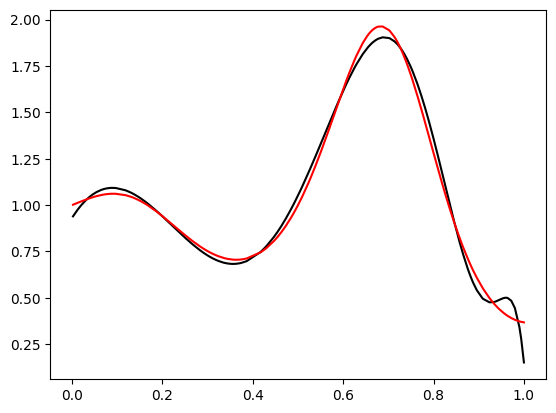

In [ ]:

own_lr = LinearRergession(lr=1e-3, num_steps=5000000).fit_gd(f_train, y_train)

y_pred = own_lr.predict(f_test)

plt.plot(x_test, y_pred, color="black")
plt.plot(x_test, y_test, color="red");

There are cases when we cannot use simple gradient descent

Whether our cost function may be expressed as a sum of functions

$$
\min f(x) = \min \frac{1}{n} \sum^{n}_{i} f(x_{i})
$$

Where $n$ is big, one GD iteration becomes expensive

$$
x_{k+1} = x_k - \alpha f'(x_k) =  x_k - \alpha  \sum^{n}_{i}  f'(x_k)
$$


Thus we may estimate our direction via some samples of the data

 $$
 h_k =  \frac{1}{m} \sum^{m}_{i} f_{i_k}'(x_{k})
 $$

and thus obtain

$$
x_{k+1} = x_k - \alpha  \sum^{n}_{i}  f'(x_k) = x_k - \alpha h_k
$$

# DEMONSTRATION


In our case we may chose not all the samples, but random subset of samples on each step

In [ ]:
class LinearRergession():
    '''LinearRergession with direct solution
    '''
    def __init__(
        self,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=5000,
    ) -> None:

        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps



    def fit (self, X_train, y_train):
        q,r = QR(X_train)
        # w = np.linalg.solve(r, q.T @ y_train)
        w = np.linalg.pinv(r) @ q.T @ y_train
        self.w = w
        return self


    def fit_gd(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):

            w -= 2 * self.lr *( np.dot(X.T, np.dot(X, w)) -(X.T@ Y)[:, None])


        self.w = w
        return self

    def fit_sgd(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):
            sample_indices = np.random.randint(n_objects, size=self.batch_size)
            w -= 2 * self.lr *( np.dot(X[sample_indices].T, np.dot(X[sample_indices], w)) -(X[sample_indices].T@ Y[sample_indices])[:, None]) / self.batch_size


        self.w = w
        return self



    def predict(self, X):
        return X@self.w

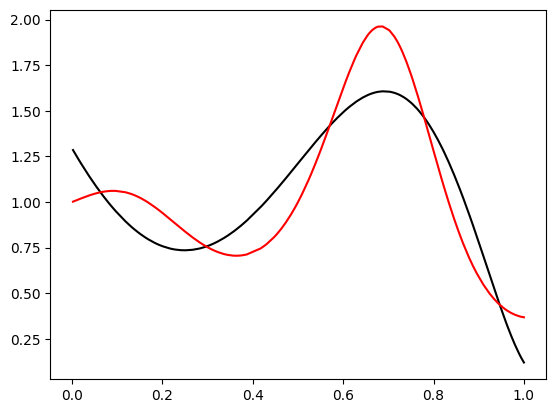

In [ ]:

own_lr = LinearRergession(lr=1e-3, num_steps=5000000).fit_sgd(f_train, y_train)

y_pred = own_lr.predict(f_test)

plt.plot(x_test, y_pred, color="black")
plt.plot(x_test, y_test, color="red");

What the flaw of these methods? They strongly depend on matrix, and matrix could be ill-conditioned!


In [ ]:
np.linalg.cond(f_train), np.linalg.cond(f_train.T @ f_train)

(3953935.918173646, 15634986268238.635)

The method convergence rate depends on the condition number of the matrix, and our matrix is ill conditioned (What is the matrix $f\_train$?). The bigger condition number the slowlier method.

#REGULARIZATION

One way to fix this issue is L2 regularization

$$
w = \arg\min \|Y - X^T w\|^2 + \lambda \|w\|^2
$$

Thus our direct solution becomes

$$
w = (X^T X + \lambda I)^{-1}X^T y
$$

The iteration of GD will looks like this


$$
x = x - 2 \alpha X^T(Xw - y) - 2 \lambda w
$$


In [ ]:
class LinearRergession():
    '''LinearRergession with direct solution
    '''
    def __init__(
        self,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=5000,
        lambd : float=1e-4
    ) -> None:

        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps
        self.lambd = lambd



    def fit (self, X_train, y_train):
        q,r = QR(X_train)
        # w = np.linalg.solve(r, q.T @ y_train)
        w = np.linalg.pinv(r) @ q.T @ y_train
        self.w = w
        return self


    def fit_gd(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):

            w -= 2 * self.lr *( np.dot(X.T, np.dot(X, w)) -(X.T@ Y)[:, None])


        self.w = w
        return self

    def fit_sgd(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):
            sample_indices = np.random.randint(n_objects, size=self.batch_size)
            w -= 2 * self.lr *( np.dot(X[sample_indices].T, np.dot(X[sample_indices], w)) -(X[sample_indices].T@ Y[sample_indices])[:, None]) / self.batch_size


        self.w = w
        return self


    def fit_gd_reg(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):

            w -= 2 * self.lr *( np.dot(X.T, np.dot(X, w)) -(X.T@ Y)[:, None]) +2 * self.lambd * w


        self.w = w
        return self



    def predict(self, X):
        return X@self.w

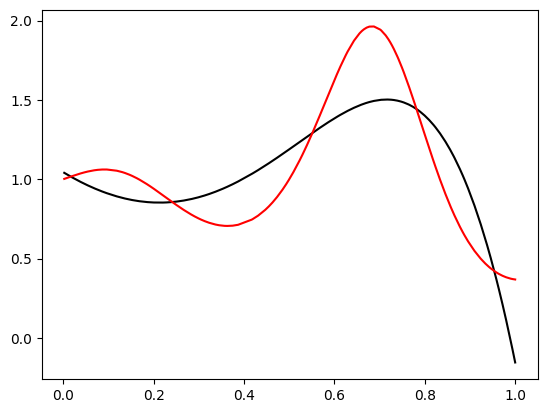

In [ ]:

own_lr = LinearRergession(lr=1e-3, num_steps=5000000).fit_gd_reg(f_train, y_train)

y_pred = own_lr.predict(f_test)

plt.plot(x_test, y_pred, color="black")
plt.plot(x_test, y_test, color="red");

We can insert regularization into SGD as well

In [ ]:
class LinearRergession():
    '''LinearRergession with direct solution
    '''
    def __init__(
        self,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=5000,
        lambd : float=1e-2
    ) -> None:

        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps
        self.lambd = lambd



    def fit (self, X_train, y_train):
        q,r = QR(X_train)
        # w = np.linalg.solve(r, q.T @ y_train)
        w = np.linalg.pinv(r) @ q.T @ y_train
        self.w = w
        return self


    def fit_gd(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):

            w -= 2 * self.lr *( np.dot(X.T, np.dot(X, w)) -(X.T@ Y)[:, None])


        self.w = w
        return self

    def fit_sgd(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):
            sample_indices = np.random.randint(n_objects, size=self.batch_size)
            w -= 2 * self.lr *( np.dot(X[sample_indices].T, np.dot(X[sample_indices], w)) -(X[sample_indices].T@ Y[sample_indices])[:, None]) / self.batch_size


        self.w = w
        return self


    def fit_gd_reg(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):

            w -= 2 * self.lr *( np.dot(X.T, np.dot(X, w)) -(X.T@ Y)[:, None]) +2 * self.lambd * w


        self.w = w
        return self


    def fit_sgd_reg(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):
            sample_indices = np.random.randint(n_objects, size=self.batch_size)
            w -= 2 * self.lr *( np.dot(X[sample_indices].T, np.dot(X[sample_indices], w)) -(X[sample_indices].T@ Y[sample_indices])[:, None] + 2 * self.lambd * w) / self.batch_size


        self.w = w
        return self


    def predict(self, X):
        return X@self.w

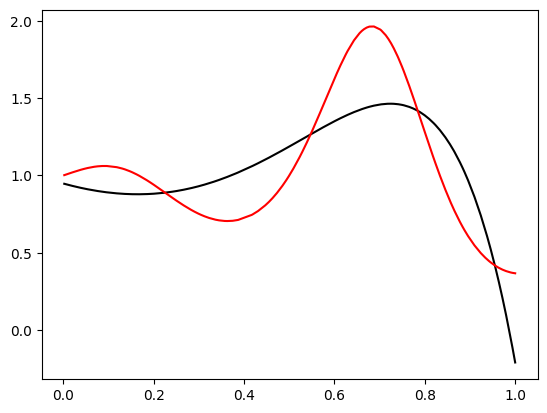

In [ ]:

own_lr = LinearRergession(lr=1e-3, num_steps=5000000).fit_sgd_reg(f_train, y_train)

y_pred = own_lr.predict(f_test)

plt.plot(x_test, y_pred, color="black")
plt.plot(x_test, y_test, color="red");

To be honest the main purpose of the l2 regularization is not to let weights become too large. But it also fixes the ill-poseness of the problem

One way to fix this issue is L2 regularization

$$
w = \arg\min \|Y - X^T w\|^2 + \lambda \|w\|^2
$$

Thus our direct solution becomes

$$
w = (X^T X + \lambda I)^{-1}X^T y
$$

$$
X = USV^T
$$
We obtain

$$
w = V(S^2 + \lambda I)^{-1}SU^T y
$$


In [ ]:
class LinearRergession():
    '''LinearRergession with direct solution
    '''
    def __init__(
        self,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=5000,
        lambd : float=1e-2
    ) -> None:

        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps
        self.lambd = lambd



    def fit (self, X_train, y_train):
        q,r = QR(X_train)
        # w = np.linalg.solve(r, q.T @ y_train)
        w = np.linalg.pinv(r) @ q.T @ y_train
        self.w = w
        return self

    def fit_reg (self, X_train, y_train):
        U, S, VT = np.linalg.svd(X_train,  full_matrices=False)

        w = np.linalg.pinv(VT) @ np.linalg.pinv(np.diag(S**2+self.lambd)) @ np.diag(S) @U.T @ y_train
        self.w = w
        return self


    def fit_gd(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):

            w -= 2 * self.lr *( np.dot(X.T, np.dot(X, w)) -(X.T@ Y)[:, None])


        self.w = w
        return self

    def fit_sgd(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):
            sample_indices = np.random.randint(n_objects, size=self.batch_size)
            w -= 2 * self.lr *( np.dot(X[sample_indices].T, np.dot(X[sample_indices], w)) -(X[sample_indices].T@ Y[sample_indices])[:, None]) / self.batch_size


        self.w = w
        return self


    def fit_gd_reg(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):

            w -= 2 * self.lr *( np.dot(X.T, np.dot(X, w)) -(X.T@ Y)[:, None]) +2 * self.lambd * w


        self.w = w
        return self


    def fit_sgd_reg(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)


        for i in range(self.num_steps):
            sample_indices = np.random.randint(n_objects, size=self.batch_size)
            w -= 2 * self.lr *( np.dot(X[sample_indices].T, np.dot(X[sample_indices], w)) -(X[sample_indices].T@ Y[sample_indices])[:, None] + 2 * self.lambd * w) / self.batch_size


        self.w = w
        return self


    def predict(self, X):
        return X@self.w

In [ ]:
N_samples = 1000
x = np.linspace(0, 1, N_samples)
np.random.seed(4)
y = np.exp(np.cos(3*np.pi*x)*x)
noise = np.random.randn(*x.shape)

ind = np.arange(N_samples, dtype=int)
ind_train = np.random.choice(ind, size=(300,), replace=False)
ind_test = np.array(list(set(ind) - set(ind_train)))

x_train, x_test = x[ind_train], x[ind_test]
y_train, y_test = y[ind_train] + noise[ind_train], y[ind_test]

n_poly = 200
f_train = np.stack([x_train**k for k in range(n_poly)], 1)
f_test = np.stack([x_test**k for k in range(n_poly)], 1)

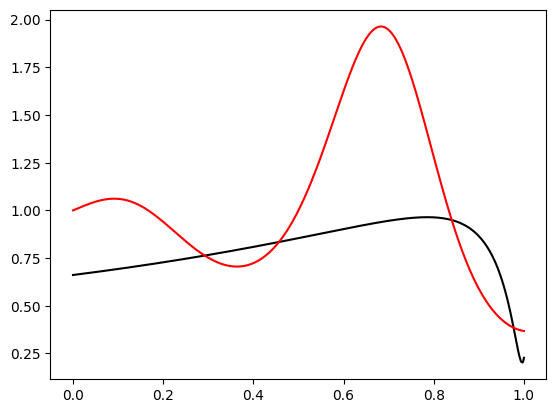

In [ ]:

own_lr = LinearRergession(lr=1e-3, num_steps=500, lambd =100).fit_reg(f_train, y_train)

y_pred = own_lr.predict(f_test)

plt.plot(x_test, y_pred, color="black")
plt.plot(x_test, y_test, color="red");

In [ ]:
np.linalg.cond(f_train.T @ f_train), np.linalg.cond(f_train.T @ f_train  + np.eye(10)* 1e-2 )

(15634986268238.635, 51746.00771764388)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1, 1], [1, 2, 1], [2, 2,2], [2, 3, 2]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2, 3])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_
reg.intercept_
reg.predict(np.array([[3, 5, 3]]))

array([25.])

In [ ]:
reg.coef_

array([2., 2., 2.])

In [ ]:
reg.coef_ += np.array([1000, 0, -1000])

In [ ]:
reg.coef_

array([ 1012.,     2., -1008.])

In [ ]:
reg.predict(np.array([[3, 5, 3]]))

array([25.])

# REAL WORLD  DATA

In [ ]:
california_housing = fetch_california_housing(as_frame=True)

In [ ]:
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
(california_housing.frame['AveRooms']/california_housing.frame['AveBedrms']).median()

4.921728151075977

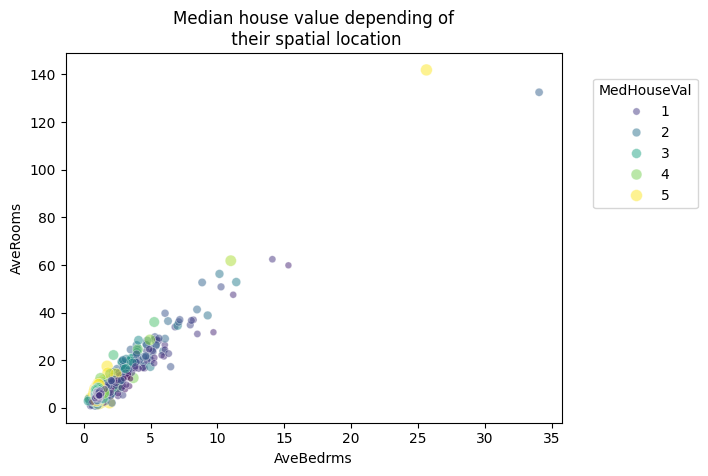

In [ ]:
import seaborn as sns

sns.scatterplot(
    data=california_housing.frame,
    x="AveBedrms",
    y="AveRooms",
    size="MedHouseVal",
    hue="MedHouseVal",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(california_housing.data, california_housing.target)

In [ ]:
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_scaled = scaler_x.transform(x_train)

scaler_y = StandardScaler()
scaler_y.fit(y_train.values[:, None])
y_scaled = scaler_y.transform(y_train.values[:, None])

x_scaled_test = scaler_x.transform(x_test)
y_scaled_test= scaler_y.transform(y_test.values[:, None])

In [ ]:
x_scaled_test = scaler_x.transform(x_test)
y_scaled_test= scaler_y.transform(y_test.values[:, None])

In [ ]:
y_train.values

array([3.219, 0.993, 1.803, ..., 1.371, 1.567, 2.439])

In [ ]:
x_train.values[:, 2]

array([6.68560606, 4.29432624, 4.87980769, ..., 6.62992126, 4.24281984,
       4.89880534])

In [ ]:
x_train.values[:, 3] * 4.91

array([7.42079545, 5.58904255, 5.26408654, ..., 4.91      , 5.37151436,
       4.99971188])

In [ ]:
from sklearn.linear_model import LinearRegression
own_lr = LinearRegression().fit(x_train.values, y_train.values)

In [ ]:
u, s, v = np.linalg.svd(x_train.values, full_matrices=True)

In [ ]:
u.shape

(15480, 15480)

In [ ]:
v.shape

(8, 8)

In [ ]:
x_train.values.shape

(15480, 8)

In [ ]:
s/s[0]

array([1.00000000e+00, 4.41033145e-02, 6.64419395e-03, 6.33966652e-03,
       1.48618835e-03, 1.00217924e-03, 7.83305448e-04, 9.91388265e-05])

In [ ]:
v[: , -1]

array([ 0.05200567,  0.92094057, -0.11647035, -0.21537358,  0.0669989 ,
        0.12302751, -0.2635549 ,  0.01126745])

In [ ]:
pred1 = own_lr.predict(x_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:
pred1

array([1.18668713, 1.59383969, 1.65180804, ..., 2.14527835, 1.20557917,
       2.42564569])

In [ ]:
own_lr.coef_

array([ 4.34455636e-01,  9.28768688e-03, -1.01799996e-01,  6.17716858e-01,
       -1.80736408e-06, -3.39439748e-03, -4.16482326e-01, -4.27330752e-01])

In [ ]:
own_lr.coef_ += v[-1, :]

In [ ]:
pred2= own_lr.predict(x_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:
pred2

array([  3.84538192,   1.86075875,  -3.234781  , ..., -14.14421974,
         9.1421162 ,  16.93136033])

In [ ]:
np.linalg.norm(y_train.values - pred2/10), np.linalg.norm(y_train.values - pred1)

(436.16368317602155, 89.51569708935261)

In [ ]:
y_train

12348    3.219
5001     0.993
11447    1.803
13658    1.115
20446    1.941
         ...  
1834     2.091
371      1.306
13530    1.371
12502    1.567
10291    2.439
Name: MedHouseVal, Length: 15480, dtype: float64

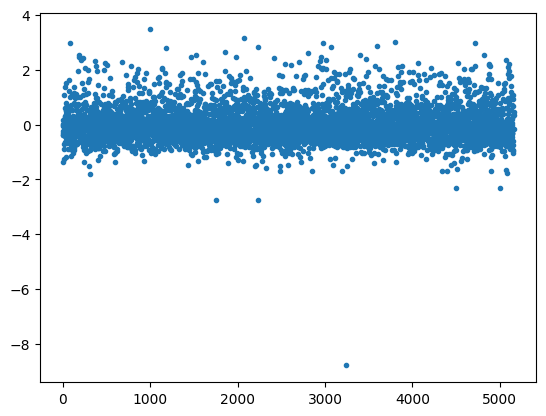

In [ ]:
residual = y_scaled_test.reshape(-1,) - own_lr.predict(x_scaled_test)
np.linalg.norm(residual) / np.linalg.norm(y_scaled_test.reshape(-1,))

plt.plot(residual, ".")

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.200e+01,
        2.110e+03, 2.673e+03, 3.190e+02, 3.300e+01]),
 array([-8.7866508 , -7.56117031, -6.33568981, -5.11020932, -3.88472882,
        -2.65924833, -1.43376784, -0.20828734,  1.01719315,  2.24267365,
         3.46815414]),
 <BarContainer object of 10 artists>)

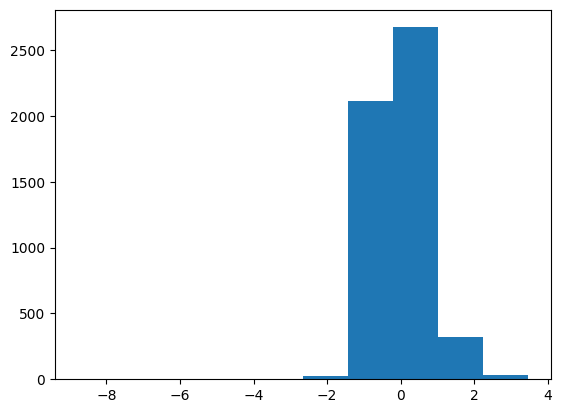

In [ ]:
plt.hist(residual)